# Time Series Forecasting in Python

Time series forecasting is a useful data science technique with applications in a wide range of industries and fields. Here’s a guide to getting started with the basic concepts behind it.

Time series forecasting is the task of predicting future values based on historical data. Examples across industries include forecasting of weather, sales numbers and stock prices. More recently, it has been applied to predicting price trends for cryptocurrencies such as Bitcoin and Ethereum. Given the prevalence of time series forecasting applications in many different fields, every data scientist should have some knowledge of the available methods for carrying it out.

A wide array of methods are available for time series forecasting. One of the most commonly used is Autoregressive Moving Average (ARMA), which is a statistical model that predicts future values using past values. This method for making time series predictions is flawed, however, because it doesn’t capture seasonal trends. It also assumes that the time series data is stationary, meaning that its statistical properties wouldn’t change over time. This type of behavior is an idealized assumption that doesn’t hold in practice, however, which means ARMA may provide skewed results. 

An extension of ARMA is the Autoregressive Integrated Moving Average (ARIMA) model, which doesn’t assume stationarity but does still assume that the data exhibits little to no seasonality. Fortunately, the seasonal ARIMA (SARIMA) variant is a statistical model that can work with non-stationary data and capture some seasonality. Additional popular time series forecasting packages are Prophet and DeepAR. Prophet is an additive model developed by Facebook where non-linear trends are fit to seasonality effects such as daily, weekly, yearly and holiday trends. DeepAR is a package developed by Amazon that enables time series forecasting with recurrent neural networks. 



Python provides many easy-to-use libraries and tools for performing time series forecasting in Python. Specifically, the stats library in Python has tools for building ARMA models, ARIMA models and SARIMA models with just a few lines of code. Since all of these models are available in a single library, you can easily run many Python forecasting experiments using different models in the same script or notebook when conducting time series forecasting in Python. 



Here, we will look at examples of time series forecasting and how to build ARMA, ARIMA and SARIMA models to make a time series prediction on the future prices of Bitcoin (BTC).

## Reading and Displaying BTC Time Series Data

We will start by reading in the historical prices for BTC using the Pandas data reader. Let’s install it:

**Install guide**
1. Go to https://www.lfd.uci.edu/~gohlke/pythonlibs/#lxml and download the correct version for your system.
2. pip install _\<path to lxml.whl>_
3. pip install pandas-datareader

 Let’s open up a Python script and import the data-reader from the Pandas library:

In [71]:
import pandas_datareader.data as web
import datetime

Let’s also import the Pandas library itself and relax the display limits on columns and rows:



In [72]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Now we have everything we need to pull Bitcoin price time series data, let’s collect data.

In [73]:
btc = web.get_data_yahoo(['BTC-USD'],
                         start=datetime.datetime(2018, 1, 1),
                         end=datetime.datetime(2020, 12, 2))['Close']
print(btc.head())

Symbols          BTC-USD
Date                    
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
2018-01-05  17429.500000


We see that our data frame contains many columns. Let’s walk through what each of these columns means.

1. Date: This is the index in our time series that specifies the date associated with the price.
2. Close: The last price at which BTC was purchased on that day.
3. Open: The first price at which BTC was purchased on that day.
4. High: The highest price at which BTC was purchased that day.
5. Low:  The lowest price at which BTC was purchased that day.
6. Volume: The number of total trades that day.
7. Adj Close: The closing price adjusted for dividends and stock splits.

We’ll use the close price for our forecasting models. Specifically, we will use historical closing BTC prices in order to predict future BTC ones.

Let’s write our closing price BTC data to a csv file. This way, we can avoid having to repeatedly pull data using the Pandas data reader. 

In [74]:
btc.to_csv("btc.csv")

Now, let’s read in our csv file and display the first five rows:

In [75]:
btc = pd.read_csv("btc.csv")
print(btc.head())

         Date       BTC-USD
0  2018-01-01  13657.200195
1  2018-01-02  14982.099609
2  2018-01-03  15201.000000
3  2018-01-04  15599.200195
4  2018-01-05  17429.500000


In order to use the models provided by the stats library, we need to set the date column to be a data frame index. We also should format that date using the to_datetime method:



In [76]:
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
del btc['Date']
btc.head()

,BTC-USD
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


Let’s plot our time series data. To do this, let’s import the data visualization libraries Seaborn and Matplotlib:

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

Let’s format our visualization using Seaborn:

In [78]:
sns.set()

And label the y-axis and x-axis using Matplotlib. We will also rotate the dates on the x-axis so that they’re easier to read, and finally, generate our plot with Matplotlib:

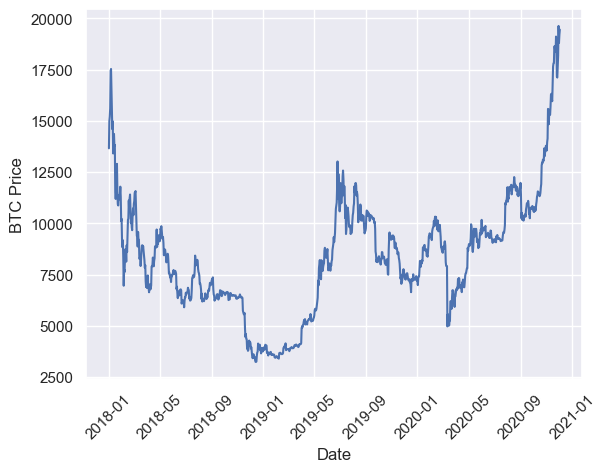

In [79]:
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['BTC-USD'])

Now we can proceed to building our first time series model, the Autoregressive Moving Average.



## Splitting Data for Training and Testing

An important part of model building is splitting our data for training and testing, which ensures that you build a model that can generalize outside of the training data and that the performance and outputs are statistically meaningful.

We will split our data such that everything before November 2020 will serve as training data, with everything after 2020 becoming the testing data:



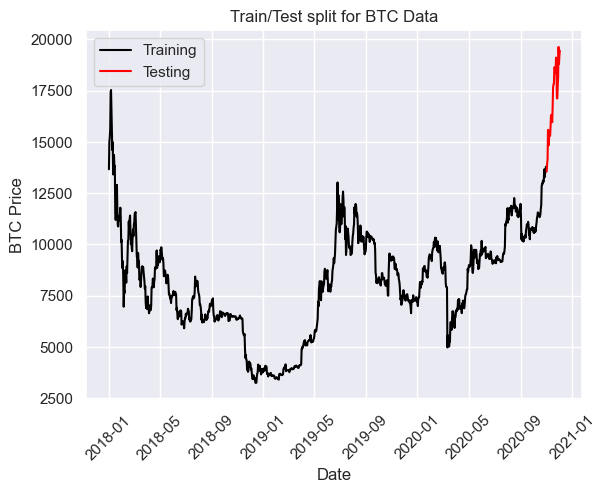

In [80]:
train = btc[btc.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2020-11-01", format='%Y-%m-%d')]

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()
plt.show()

## Autoregressive Moving Average (ARMA)

The term “autoregressive” in ARMA means that the model uses past values to predict future ones. Specifically, predicted values are a weighted linear combination of past values. This type of regression method is similar to linear regression, with the difference being that the feature inputs here are historical values. 

Moving average refers to the predictions being represented by a weighted, linear combination of white noise terms, where white noise is a random signal. The idea here is that ARMA uses a combination of past values and white noise in order to predict future values. Autoregression models market participant behavior like buying and selling BTC. The white noise models shock events like wars, recessions and political events. 

We can define an ARMA model using the SARIMAX package:



In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Let’s define our input:

In [82]:
y = train['BTC-USD']
z = test['BTC-USD']

And then let’s define our model. To define an ARMA model with the SARIMAX class, we pass in the order parameters of (1, 0 ,1). Alpha corresponds to the significance level of our predictions. Typically, we choose an alpha = 0.05. Here, the ARIMA algorithm calculates upper and lower bounds around the prediction such that there is a 5 percent chance that the real value will be outside of the upper and lower bounds. This means that there is a 95 percent confidence that the real value will be between the upper and lower bounds of our predictions.

In [83]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


We can then fit our model:

In [84]:
ARMAmodel = ARMAmodel.fit()

Generate our predictions:



In [85]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

And plot the results:

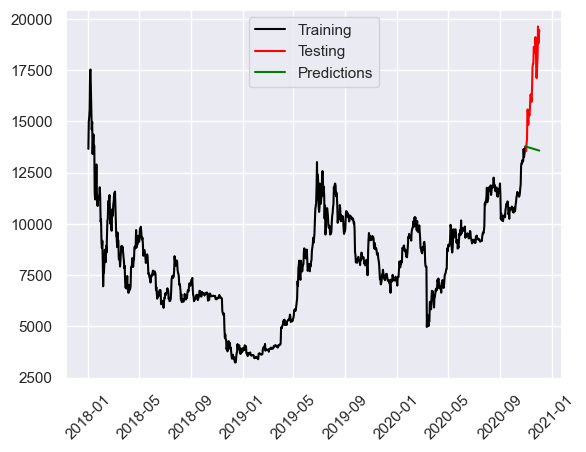

In [93]:
plt.plot(y, color='black', label = 'Training')
plt.plot(z, color='red', label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

We can also evaluate the performance using the root mean-squared error:



In [87]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df["Predictions"]))
print("RMSE: ", arma_rmse)

RMSE:  3736.389105452206


The RMSE is pretty high, which we could have guessed upon inspecting the plot. Unfortunately, the model predicts a decrease in price when the price actually increases. Again, ARMA is limited in that it fails for non-stationary time series and does not capture seasonality. Let’s see if we can improve performance with an ARIMA model. 

## Autoregressive Integrated Moving Average (ARIMA)


Let’s import the ARIMA package from the stats library:



In [88]:
from statsmodels.tsa.arima.model import ARIMA


An ARIMA task has three parameters. The first parameter corresponds to the lagging (past values), the second corresponds to differencing (this is what makes non-stationary data stationary), and the last parameter corresponds to the white noise (for modeling shock events). 



Let’s define an ARIMA model with order parameters (2,2,2):



C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


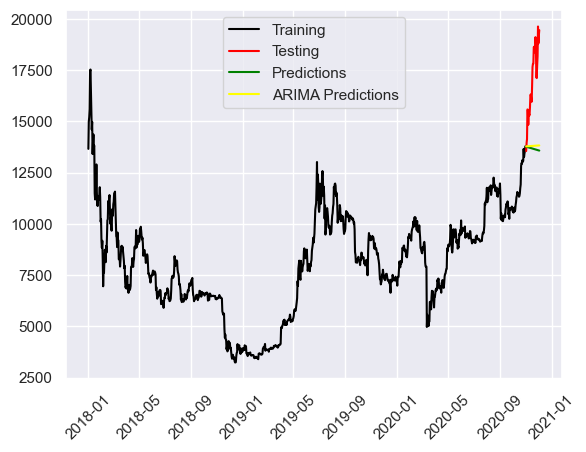

RMSE:  3588.244312741313


In [95]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_arima = y_pred.conf_int(alpha = 0.05) 
y_pred_df_arima["Predictions"] = ARIMAmodel.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])
y_pred_df_arima.index = test.index
y_pred_out_arima = y_pred_df_arima["Predictions"]

plt.plot(y, color='black', label = 'Training')
plt.plot(z, color='red', label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(y_pred_out_arima, color='Yellow', label = 'ARIMA Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df_arima["Predictions"]))
print("RMSE: ", arma_rmse)

We see that the ARIMA predictions (in yellow) fall on top of the ARMA predictions. Let’s try increasing the differencing parameter to ARIMA (2,3,2):

C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


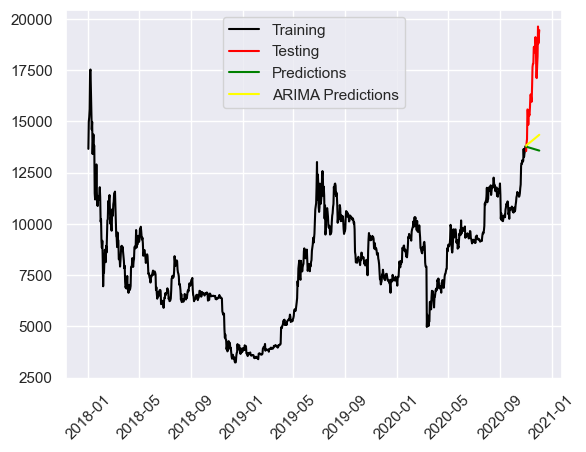

RMSE:  3281.3537646273267


In [96]:
ARIMAmodel = ARIMA(y, order = (2, 3, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_arima = y_pred.conf_int(alpha = 0.05) 
y_pred_df_arima["Predictions"] = ARIMAmodel.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])
y_pred_df_arima.index = test.index
y_pred_out_arima = y_pred_df_arima["Predictions"]

plt.plot(y, color='black', label = 'Training')
plt.plot(z, color='red', label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(y_pred_out_arima, color='Yellow', label = 'ARIMA Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df_arima["Predictions"]))
print("RMSE: ", arma_rmse)

We see this helps capture the increasing price direction. Let’s try playing with the parameters even further with ARIMA(5,4,2):

C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\AhmetP

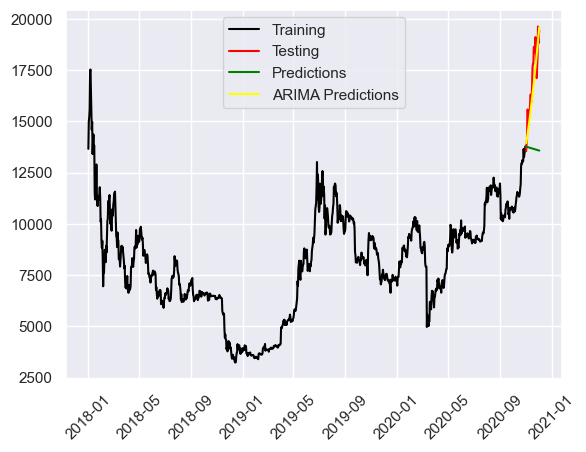

RMSE:  878.8042963063828


In [97]:
ARIMAmodel = ARIMA(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_arima = y_pred.conf_int(alpha = 0.05) 
y_pred_df_arima["Predictions"] = ARIMAmodel.predict(start = y_pred_df_arima.index[0], end = y_pred_df_arima.index[-1])
y_pred_df_arima.index = test.index
y_pred_out_arima = y_pred_df_arima["Predictions"]

plt.plot(y, color='black', label = 'Training')
plt.plot(z, color='red', label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(y_pred_out_arima, color='Yellow', label = 'ARIMA Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df_arima["Predictions"]))
print("RMSE: ", arma_rmse)

And we have an RMSE of 878, which is better than ARMA. Another approach is to train a linear regression model on temporal features such as week, month, and year. This approach is limited since it does not capture autoregressive and moving average features like the ARIMA method. Further, ARIMA trains regressors on detrended lagged target values as opposed to independent variables like linear regression. With this being said ARIMA would likely outperform a linear regression model trained on independent temporal variables. 

Finally, let’s see if SARIMA, which incorporates seasonality, will further improve performance. 

## Seasonal ARIMA (SARIMA)


Seasonal ARIMA captures historical values, shock events and seasonality. We can define a SARIMA model using the SARIMAX class:



C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\AhmetPekbas(Delegate\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed 

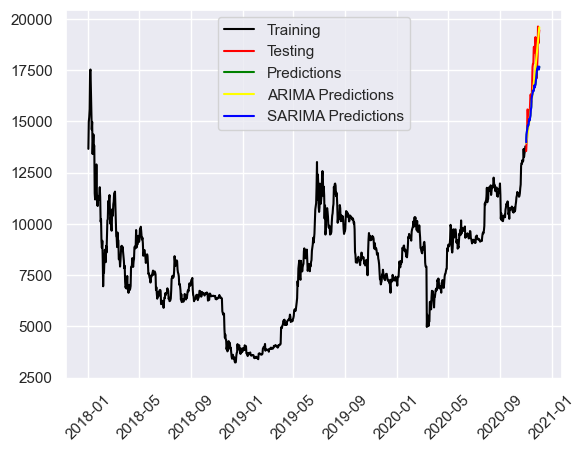

RMSE:  1167.9001059155257


In [100]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df_sarima = y_pred.conf_int(alpha = 0.05) 
y_pred_df_sarima["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_sarima.index[0], end = y_pred_df_sarima.index[-1])
y_pred_df_sarima.index = test.index
y_pred_out_sarima = y_pred_df_sarima["Predictions"] 

plt.plot(y, color='black', label = 'Training')
plt.plot(z, color='red', label = 'Testing')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(y_pred_out_arima, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_out_sarima, color='Blue', label = 'SARIMA Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_df_sarima["Predictions"]))
print("RMSE: ", arma_rmse)

Here we have an RMSE of 1167, which is slightly worse than ARIMA. This may be due to lack of hyperparameter tuning. If we play around with the parameters for our SARIMA model we should be able to improve performance even further. 

I encourage you to experiment with the hyperparameters to see if you can build a SARIMA model that outperforms ARIMA. Further, you can employ methods like grid search to algorithmically find the best parameters for each model. 